In [1]:
# autoreload to reload modules when they change
%load_ext autoreload
%autoreload 2

import rollout
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [2]:

d_model = 256
n_tokens = 10
sequence_length = 6
n_heads = 1
dataset = rollout.dataset.InductionDataset(n_tokens, sequence_length)
simpleModel = rollout.models.SimpleTransformer(d_model, n_tokens, sequence_length, n_heads)
optimizer = optim.AdamW(simpleModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

simple_train_losses, simple_test_losses = rollout.models.optimize_model(simpleModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.4862475395202637, Test Loss: 2.3510284423828125
Epoch 100: Train Loss: 1.3486535549163818, Test Loss: 1.3365025520324707
Epoch 200: Train Loss: 1.289481520652771, Test Loss: 1.289735198020935
Epoch 300: Train Loss: 1.302837610244751, Test Loss: 1.2885851860046387
Epoch 400: Train Loss: 1.297789454460144, Test Loss: 1.2576392889022827


In [5]:
d_model = 128
n_heads = 1

complexModel = rollout.models.ComplexTransformer(d_model, n_tokens, sequence_length, n_heads)
optimizer = optim.AdamW(complexModel.parameters(), lr=0.001)
criterion = nn.functional.cross_entropy

complex_train_losses, complex_test_losses =  rollout.models.optimize_model(complexModel, criterion, optimizer, dataset, n_epochs=500, batch_size=1024)

Epoch 0: Train Loss: 2.4899964332580566, Test Loss: 2.388885974884033
Epoch 100: Train Loss: 0.088829904794693, Test Loss: 0.06223958358168602
Epoch 200: Train Loss: 0.00014954328071326017, Test Loss: 0.000168540544109419
Epoch 300: Train Loss: 9.832931391429156e-05, Test Loss: 0.000144923513289541
Epoch 400: Train Loss: 8.600549335824326e-05, Test Loss: 8.520079427398741e-05


In [6]:
num_simple_params = sum(p.numel() for p in simpleModel.parameters() if p.requires_grad)
num_complex_params = sum(p.numel() for p in complexModel.parameters() if p.requires_grad)
print(f"Simple model has {num_simple_params} parameters")
print(f"Complex model has {num_complex_params} parameters")

Simple model has 268298 parameters
Complex model has 134666 parameters


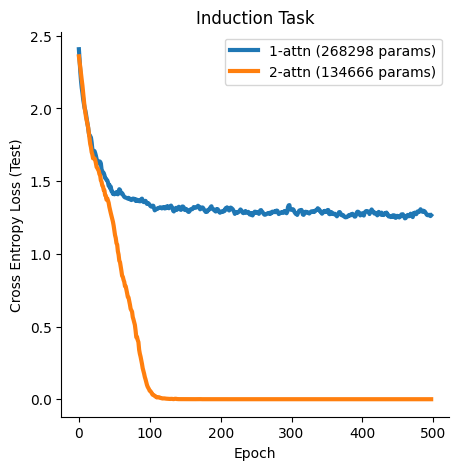

In [7]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(rollout.utils.movmean(np.array(simple_train_losses), 3), label=f"1-attn ({num_simple_params} params)", lw=3)
ax.plot(rollout.utils.movmean(np.array(complex_test_losses), 3), label=f"2-attn ({num_complex_params} params)", lw=3)
ax.set_ylabel("Cross Entropy Loss (Test)")  
ax.legend()
ax.set_title("Induction Task")
ax.set_xlabel("Epoch")
sns.despine()

In [14]:
X, y = dataset.generate_batch(100, type="test")
x = complexModel.embed(X)
x = x + complexModel.position(X)
a_1, a_w =complexModel.attention_layer_1(x, x, x, need_weights=True, attn_mask=torch.triu(torch.ones(sequence_length, sequence_length)))
x = x + a_1
a_2, a_w2 = complexModel.attention_layer_2(x, x, x, need_weights=True, attn_mask=torch.triu(torch.ones(sequence_length, sequence_length)))
x = x + a_2

pred = complexModel(X)
y_pred = torch.argmax(pred, dim=1)

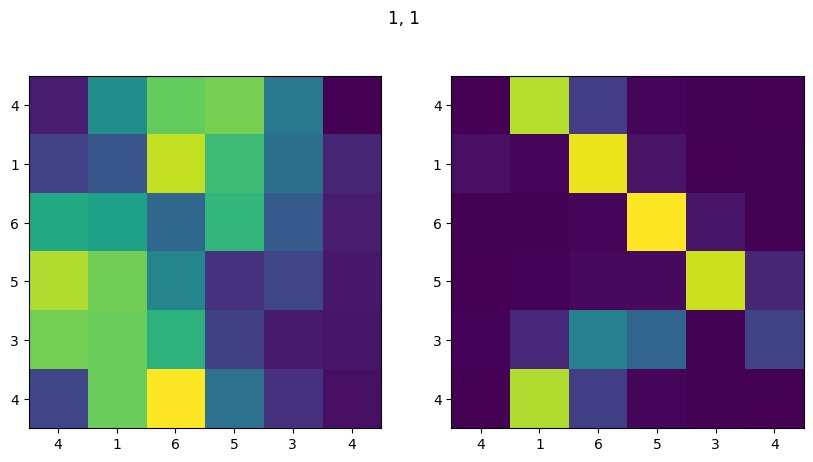

In [17]:
sample = np.random.randint(0, len(y))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(a_w.detach().numpy()[sample])
ax[1].imshow(a_w2.detach().numpy()[sample])
for i in range(2):
    ax[i].set_xticks(np.arange(sequence_length), labels=X[sample].numpy())
    ax[i].set_yticks(np.arange(sequence_length), labels=X[sample].numpy())
fig.suptitle(f"{y[sample]}, {y_pred[sample]}")
plt.show()